This feature selection notebook does a filter followed by a wrapper for a binary dependent variable (binary classification). It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ... Or you can make the input file name(s) anything you want.

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the RATIO OF BADS TO GOODS retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. I think in general it's better to keep balance = 0.

The filter is pretty fast. The wrapper is what takes the most time. The two most important paramenters are the number of variables you want to save from the filter (num_filter) and the number you want from the wrapper (num_wrapper). 

There's a parameter njobs that controls the # threads used in the wrapper. Set it to 1 for a single thread and it should work fine, but you might be able to succeed with njobs = -1, which lets the machine set the maximum # threads based on the CPU. With this setting the kernel may die because of memory. The njobs = -1 doesn't take into consideration the memory requirements.

Recommendations: Try a few simple runs just to make sure all's working. Start with num_filter = 20, num_wrapper = 5, increase from there. I like num_filter as high as around 10 to 20% of the # candidate variables, but not much higher than a few hundred. You don't need num_wrapper large if you're doing forward selection. Most problems will saturate before 20. You can try a few different simple wrapper models like RF (5 trees, 10 layers), catboost (10 trees, 3 layers), LGBM (same). They're pretty fast. You can try forward and backward. I'd start with forward. In the end, select one of these as your favorite run and go with those variables. Don't mix variables across different runs.

I find forward selection runs much faster than backward.

Make sure your validation/out-of-time population and any other record exclusion is set correctly and as you want for your problem in cell 3.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [2]:
# set some parameters
num_files = 1 # This is number of files you have for feature selection. Usually this will just be 1.

# This is the number of variables from the filter that you want the wrapper to consider.
# Make it as high as your machine and time can handle. 
# I recommend set num_filter to be at least about 10 to 20% of the original # variables. 
num_filter = 150

# I recommend set num_wrapper to be about 30, then look for a saturation of the model performance as variables are added
# Then you can run it again with num_wrapper about twice this saturation number.
num_wrapper = 30

balance = 0 # a nonzero value will then be ratio of goods to bads.

# This is a cutpoint for measuring a detection rate. It's not that important to get it exact. 
# Set it around where you think the business cutoff is expected to be.
detect_rate = .03

index_name = 'record'  # set this string as whatever your record number field is called
y_name = 'fraud_label' # set this string to be whatever your binary label is called
good_label = 0  # you can make the goods or bads zero or 1. If you want high to be bad, then set bad=1, good=0.
bad_label = 1

# You need to explicitly set these record numbers in the next two lines. They define the range of records you want to use for feature selection.
# Frequently we want to ignore some early records (if not, set the ignore_records_below to 0)
# We may want to ignore some later records, for example an out-of-time data set.
ignore_records_above = 833507 # remove the last two months as the out-of-time data (OOT)
ignore_records_below = 38511 # remove the first 2 weeks of records since their variables aren't well formed

## Run a filter on all the files

In [3]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'vars (1).csv' # if you only have one file for variables, set num_files=1 and put the name of the file here.
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
# you need to explicitly set these record numbers in the next two lines. They define the range of records you want to use for feature selection.
# frequently we want to ignore some early records (if not, set the )
    df = df[df.index <= ignore_records_above] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= ignore_records_below] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','filter score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)

    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on vars (1).csv size is (1000000, 654)
100
200
300
400
500
600
vars (1).csv                                        variable  filter score
0                                   fraud_label      1.000000
613                 max_count_by_fulladdress_30      0.359914
593                     max_count_by_address_30      0.359215
592                      max_count_by_address_7      0.343335
612                  max_count_by_fulladdress_7      0.343052
11                            address_day_since      0.334140
46                        fulladdress_day_since      0.333269
17                             address_count_30      0.332648
52                         fulladdress_count_30      0.331969
611                  max_count_by_fulladdress_3      0.329538
591                      max_count_by_address_3      0.329445
16                             address_count_14      0.322436
51                         fulladdress_count_14      0.321953
590                      max_count_by

In [4]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)

In [5]:
filter_score.head(30)

variable  filter score
0                                      fraud_label      1.000000
1                      max_count_by_fulladdress_30      0.359914
2                          max_count_by_address_30      0.359215
3                           max_count_by_address_7      0.343335
4                       max_count_by_fulladdress_7      0.343052
5                                address_day_since      0.334140
6                            fulladdress_day_since      0.333269
7                                 address_count_30      0.332648
8                             fulladdress_count_30      0.331969
9                       max_count_by_fulladdress_3      0.329538
10                          max_count_by_address_3      0.329445
11                                address_count_14      0.322436
12                            fulladdress_count_14      0.321953
13                          max_count_by_address_1      0.315332
14                      max_count_by_fulladdress_1      0.315253
15                                 address_count_7      0.301735
16                             fulladdress_count_7      0.301666
17      address_unique_count_for_name_homephone_60      0.292438
18                           address_count_0_by_30      0.291922
19                       fulladdress_count_0_by_30      0.290722
20  fulladdress_unique_count_for_name_homephone_60      0.289535
21                address_unique_count_for_name_60      0.287411
22             fulladdress_unique_count_for_ssn_60      0.286764
23                 address_unique_count_for_ssn_60      0.285913
24        fulladdress_unique_count_for_name_dob_60      0.284534
25      address_unique_count_for_name_homephone_30      0.284516
26  fulladdress_unique_count_for_name_homephone_30      0.283563
27             fulladdress_unique_count_for_dob_60      0.282967
28                 address_unique_count_for_dob_60      0.282069
29             fulladdress_unique_count_for_ssn_30      0.281847

In [6]:
filter_score.tail(10)

variable  filter score
644              name_homephone_unique_count_for_dob_3      0.000039
645              name_homephone_unique_count_for_dob_0      0.000038
646            name_fulladdress_unique_count_for_dob_0      0.000037
647                    address_unique_count_for_zip5_0      0.000033
648  name_homephone_unique_count_for_fulladdress_dob_0      0.000009
649             name_homephone_unique_count_for_zip5_0      0.000005
650          name_fulladdress_unique_count_for_zip5_30      0.000001
651                                    ssn_fulladdress      0.000000
652         address_unique_count_for_fulladdress_dob_0      0.000000
653                                              dummy      0.000000

In [7]:
filter_score.shape

(654, 2)

In [8]:
filter_score.head(80).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['max_count_by_fulladdress_30', 'max_count_by_address_30', 'max_count_by_address_7', 'max_count_by_fulladdress_7', 'address_day_since', 'fulladdress_day_since', 'address_count_30', 'fulladdress_count_30', 'max_count_by_fulladdress_3', 'max_count_by_address_3', 'address_count_14', 'fulladdress_count_14', 'max_count_by_address_1', 'max_count_by_fulladdress_1', 'address_count_7', 'fulladdress_count_7', 'address_unique_count_for_name_homephone_60', 'address_count_0_by_30', 'fulladdress_count_0_by_30', 'fulladdress_unique_count_for_name_homephone_60', 'address_unique_count_for_name_60', 'fulladdress_unique_count_for_ssn_60', 'address_unique_count_for_ssn_60', 'fulladdress_unique_count_for_name_dob_60', 'address_unique_count_for_name_homephone_30', 'fulladdress_unique_count_for_name_homephone_30', 'fulladdress_unique_count_for_dob_60', 'address_unique_count_for_dob_60', 'fulladdress_unique_count_for_ssn_30', 'address_count_0_by_14', 'fulladdress_count_0_by_14', 'address_unique_

In [9]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

max_count_by_fulladdress_30  max_count_by_address_30  \
record                                                         
38511                            14                       14   
38512                             1                        1   
38513                             1                        1   
38514                             1                        1   
38515                             1                        1   

        max_count_by_address_7  max_count_by_fulladdress_7  address_day_since  \
record                                                                          
38511                       10                          10                0.0   
38512                        1                           1              365.0   
38513                        1                           1              365.0   
38514                        1                           1              365.0   
38515                        1                           1              365.0   

        fulladdress_day_since  address_count_30  fulladdress_count_30  \
record                                                                  
38511                     0.0                12                    12   
38512                   365.0                 1                     1   
38513                   365.0                 1                     1   
38514                   365.0                 1                     1   
38515                   365.0                 1                     1   

        max_count_by_fulladdress_3  max_count_by_address_3  ...  zip5_count_0  \
record                                                      ...                 
38511                            6                       6  ...             2   
38512                            1                       1  ...             1   
38513                            1                       1  ...             1   
38514                            1                       1  ...             1   
38515                            1                       1  ...             1   

        max_count_by_name_1  homephone_count_14  name_count_7  \
record                                                          
38511                     1                   3             2   
38512                     1                   4             1   
38513                     1                   6             1   
38514                     1                   2             1   
38515                     1                   1             1   

        zip5_unique_count_for_ssn_0  zip5_unique_count_for_name_homephone_0  \
record                                                                        
38511                             2                                       2   
38512                             1                                       1   
38513                             1                                       1   
38514                             1                                       1   
38515                             1                                       1   

        zip5_unique_count_for_dob_0  zip5_unique_count_for_name_fulladdress_0  \
record                                                                          
38511                             2                                         2   
38512                             1                                         1   
38513                             1                                         1   
38514                             1                                         1   
38515                             1                                         1   

        zip5_unique_count_for_name_0  name_count_0_by_30  
record                                                    
38511                              2                15.0  
38512                              1                30.0  
38513                              1                30.0  
38514                              1  

In [10]:
df_keep.shape

(794997, 150)

In [11]:
Y.head()

fraud_label
record             
38511             1
38512             0
38513             0
38514             0
38515             0

In [12]:
Y = Y.values.ravel()
Y_save = Y.copy()

In [13]:
# Y = np.array(Y)
X = df_keep
print(Y)

[1 0 0 ... 0 0 0]


In [14]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:02:19.977710


In [15]:
print(X.shape,Y.shape)

(794997, 150) (794997,)


In [16]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [17]:
def fdr(classifier, x, y, cutoff=0.03):
    # Calculates FDR score for the given classifier on dataset x and y with cutoff value
    return fdr_prob(y, classifier.predict_proba(x), cutoff)

def fdr_prob(y, y_prob, cutoff=0.03):
    if len(y_prob.shape) > 1:  # Check if y_prob is multi-dimensional
        y_prob = y_prob[:, -1]  # Use the last column if it's for the positive class
    y_prob = y_prob.flatten()  # Ensure y_prob is 1D
    num_fraud = np.sum(y == 1)  # Count the total number of frauds

    # Sort the proba list from high to low while retaining the true (not predicted) fraud label
    sorted_prob = np.array(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_index = int(len(y) * cutoff)  # Calculate index for cutoff
    cutoff_bin = sorted_prob[:cutoff_index, 1]  # Get labels up to the cutoff

    # Return the FDR score (#fraud_in_cutoff / #total_fraud)
    return np.sum(cutoff_bin == 1) / num_fraud if num_fraud > 0 else 0

## Run a wrapper on the remaining top variables

In [18]:
# This is a parallel running parameter. You can try it set to -1, but sometimes the data is too large to
# be divided into that many threads and the next cell quits. A safe value is 1 for no parallelization but it 
# the runs slower. You might experiment to see how big you can set this for your data on your machine.
njobs = 1

In [19]:
%%time
import warnings 
warnings.filterwarnings("ignore") 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get a sorted list of num_wrapper variables.

nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=10,num_leaves=3) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=2,n_jobs=njobs) # use for forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=2,n_jobs=njobs) # use for backward selection
sfs.fit(X,Y)

[LightGBM] [Info] Number of positive: 5743, number of negative: 391755
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 397498, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014448 -> initscore=-4.222655
[LightGBM] [Info] Start training from score -4.222655
[LightGBM] [Info] Number of positive: 5744, number of negative: 391755
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 397499, number of used features: 1
[LightGBM] [Info] [bin

SequentialFeatureSelector(cv=2,
                          estimator=LGBMClassifier(n_estimators=10,
                                                   num_leaves=3),
                          k_features=(30, 30),
                          scoring=<function fdr at 0x16bd6fce0>)

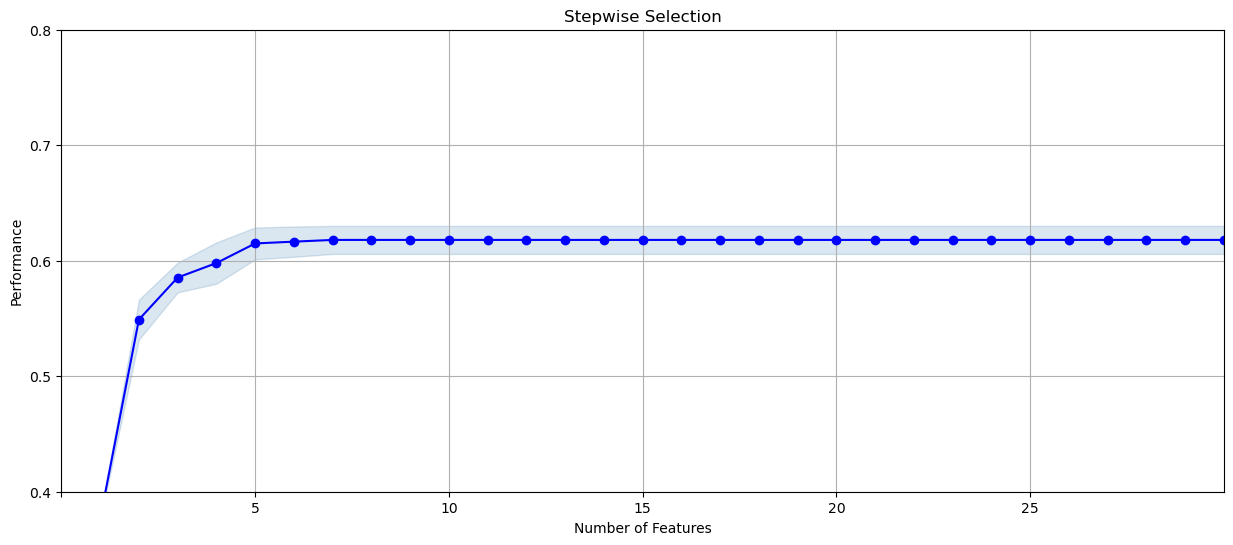

In [20]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, num_wrapper, step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([.4,.8])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('performance_nvars.png')
plt.show()

In [21]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [22]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))[0]
# You might also need this following line. It converts a list to a string
#         ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]

In [23]:
ordered_vars_FS

feature_idx  \
1                                                (1,)   
2                                             (1, 84)   
3                                         (1, 79, 84)   
4                                    (1, 79, 84, 100)   
5                                 (0, 1, 79, 84, 100)   
6                             (0, 1, 18, 79, 84, 100)   
7                         (0, 1, 18, 79, 84, 85, 100)   
8                      (0, 1, 2, 18, 79, 84, 85, 100)   
9                   (0, 1, 2, 4, 18, 79, 84, 85, 100)   
10               (0, 1, 2, 4, 5, 18, 79, 84, 85, 100)   
11            (0, 1, 2, 4, 5, 8, 18, 79, 84, 85, 100)   
12         (0, 1, 2, 4, 5, 8, 9, 18, 79, 84, 85, 100)   
13     (0, 1, 2, 4, 5, 8, 9, 10, 18, 79, 84, 85, 100)   
14  (0, 1, 2, 4, 5, 8, 9, 10, 11, 18, 79, 84, 85, ...   
15  (0, 1, 2, 4, 5, 8, 9, 10, 11, 12, 18, 79, 84, ...   
16  (0, 1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 18, 79, ...   
17  (0, 1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 14, 18, ...   
18  (0, 1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, ...   
19  (0, 1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, ...   
20  (0, 1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, ...   
21  (0, 1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, ...   
22  (0, 1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, ...   
23  (0, 1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, ...   
24  (0, 1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, ...   
25  (0, 1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, ...   
26  (0, 1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, ...   
27  (0, 1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, ...   
28  (0, 1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, ...   
29  (0, 1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, ...   
30  (0, 1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, ...   

                                   cv_scores avg_score  \
1   [0.3777855153203343, 0.3750652968831621]  0.376425   
2   [0.5318593314763231, 0.5662545707818214]  0.549057   
3   [0.5725974930362117, 0.5982935747866969]  0.585446   
4     [0.58008356545961, 0.6158802019850252]  0.597982   
5   [0.6011490250696379, 0.6287654535956817]  0.614957   
6   [0.6034122562674095, 0.6296360787045099]  0.616524   
7   [0.6058495821727019, 0.6301584537698067]  0.618004   
8   [0.6058495821727019, 0.6301584537698067]  0.618004   
9   [0.6058495821727019, 0.6301584537698067]  0.618004   
10  [0.6058495821727019, 0.6301584537698067]  0.618004   
11  [0.6058495821727019, 0.6301584537698067]  0.618004   
12  [0.6058495821727019, 0.6301584537698067]  0.618004   
13  [0.6058495821727019, 0.6301584537698067]  0.618004   
14  [0.6058495821727019, 0.6301584537698067]  0.618004   
15  [0.6058495821727019, 0.6301584537698067]  0.618004   
16  [0.6058495821727019, 0.6301584537698067]  0.618004   
17  [0.6058495821727019, 0.6301584537698067]  0.618004   
18  [0.6058495821727019, 0.6301584537698067]  0.618004   
19  [0.6058495821727019, 0.6301584537698067]  0.618004   
20  [0.6058495821727019, 0.6301584537698067]  0.618004   
21  [0.6058495821727019, 0.6301584537698067]  0.618004   
22  [0.6058495821727019, 0.6301584537698067]  0.618004   
23  [0.6058495821727019, 0.6301584537698067]  0.618004   
24  [0.6058495821727019, 0.6301584537698067]  0.618004   
25  [0.6058495821727019, 0.6301584537698067]  0.618004   
26  [0.6058495821727019, 0.6301584537698067]  0.618004   
27  [0.6058495821727019, 0.6301584537698067]  0.618004   
28  [0.6058495821727019, 0.6301584537698067]  0.618004   
29  [0.6058495821727019, 0.6301584537698067]  0.618004   
30  [0.6058495821727019, 0.6301584537698067]  0.618004   

                                        feature_names  ci_bound   std_dev  \
1                          (max_count_by_address_30,)  0.005852   0.00136   
2       (max_count_by_address_30, max_count_by_ssn_7)  0.073995  0.017198   
3   (max_count_by_address_30, max_count_by_homepho...  0.055281  0.012848   
4   (max_count_by_address_30, max_count_by_homepho...   0.07701  0.017898   
5   (max_count_by_fulladdress_30, max_count_by_add...  0.059412  0.013808   
6   (max_coun

In [24]:
ordered_vars_FS.to_csv('Wrapper_selection_info.csv', index=False)

In [25]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)
vars_keep

1                            max_count_by_address_30
2                                 max_count_by_ssn_7
3                           max_count_by_homephone_7
4                        zip5_unique_count_for_dob_1
5                        max_count_by_fulladdress_30
6                          fulladdress_count_0_by_30
7                                      ssn_day_since
8                             max_count_by_address_7
9                                  address_day_since
10                             fulladdress_day_since
11                        max_count_by_fulladdress_3
12                            max_count_by_address_3
13                                  address_count_14
14                              fulladdress_count_14
15                            max_count_by_address_1
16                        max_count_by_fulladdress_1
17                                   address_count_7
18                               fulladdress_count_7
19        address_unique_count_for_name_homeph

In [26]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

filter score
variable                                                
max_count_by_fulladdress_30                     0.359914
max_count_by_address_30                         0.359215
max_count_by_address_7                          0.343335
max_count_by_fulladdress_7                      0.343052
address_day_since                               0.334140
...                                                  ...
name_homephone_unique_count_for_zip5_0          0.000005
name_fulladdress_unique_count_for_zip5_30       0.000001
ssn_fulladdress                                 0.000000
address_unique_count_for_fulladdress_dob_0      0.000000
dummy                                           0.000000

[653 rows x 1 columns]

In [27]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

Empty DataFrame
Columns: []
Index: [max_count_by_address_30, max_count_by_ssn_7, max_count_by_homephone_7, zip5_unique_count_for_dob_1, max_count_by_fulladdress_30]

In [28]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')

In [29]:
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted.csv',index=False)
vars_keep_sorted

wrapper order                                        variable  \
0               1                         max_count_by_address_30   
1               2                              max_count_by_ssn_7   
2               3                        max_count_by_homephone_7   
3               4                     zip5_unique_count_for_dob_1   
4               5                     max_count_by_fulladdress_30   
5               6                       fulladdress_count_0_by_30   
6               7                                   ssn_day_since   
7               8                          max_count_by_address_7   
8               9                               address_day_since   
9              10                           fulladdress_day_since   
10             11                      max_count_by_fulladdress_3   
11             12                          max_count_by_address_3   
12             13                                address_count_14   
13             14                            fulladdress_count_14   
14             15                          max_count_by_address_1   
15             16                      max_count_by_fulladdress_1   
16             17                                 address_count_7   
17             18                             fulladdress_count_7   
18             19      address_unique_count_for_name_homephone_60   
19             20                           address_count_0_by_30   
20             21  fulladdress_unique_count_for_name_homephone_60   
21             22                address_unique_count_for_name_60   
22             23             fulladdress_unique_count_for_ssn_60   
23             24                 address_unique_count_for_ssn_60   
24             25        fulladdress_unique_count_for_name_dob_60   
25             26      address_unique_count_for_name_homephone_30   
26             27  fulladdress_unique_count_for_name_homephone_30   
27             28             fulladdress_unique_count_for_dob_60   
28             29                 address_unique_count_for_dob_60   
29             30             fulladdress_unique_count_for_ssn_30   

    filter score  
0       0.359215  
1       0.227428  
2       0.232235  
3       0.219066  
4       0.359914  
5       0.290722  
6       0.227146  
7       0.343335  
8       0.334140  
9       0.333269  
10      0.329538  
11      0.329445  
12      0.322436  
13      0.321953  
14      0.315332  
15      0.315253  
16      0.301735  
17      0.301666  
18      0.292438  
19      0.291922  
20      0.289535  
21      0.287411  
22      0.286764  
23      0.285913  
24      0.284534  
25      0.284516  
26      0.283563  
27      0.282967  
28      0.282069  
29      0.281847

In [30]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['max_count_by_address_30',
 'max_count_by_ssn_7',
 'max_count_by_homephone_7',
 'zip5_unique_count_for_dob_1',
 'max_count_by_fulladdress_30',
 'fulladdress_count_0_by_30',
 'ssn_day_since',
 'max_count_by_address_7',
 'address_day_since',
 'fulladdress_day_since',
 'max_count_by_fulladdress_3',
 'max_count_by_address_3',
 'address_count_14',
 'fulladdress_count_14',
 'max_count_by_address_1',
 'max_count_by_fulladdress_1',
 'address_count_7',
 'fulladdress_count_7',
 'address_unique_count_for_name_homephone_60',
 'address_count_0_by_30',
 'fulladdress_unique_count_for_name_homephone_60',
 'address_unique_count_for_name_60',
 'fulladdress_unique_count_for_ssn_60',
 'address_unique_count_for_ssn_60',
 'fulladdress_unique_count_for_name_dob_60',
 'address_unique_count_for_name_homephone_30',
 'fulladdress_unique_count_for_name_homephone_30',
 'fulladdress_unique_count_for_dob_60',
 'address_unique_count_for_dob_60',
 'fulladdress_unique_count_for_ssn_30',
 'record',
 'fraud_label']

In [31]:
filter_score

filter score
variable                                                
max_count_by_fulladdress_30                     0.359914
max_count_by_address_30                         0.359215
max_count_by_address_7                          0.343335
max_count_by_fulladdress_7                      0.343052
address_day_since                               0.334140
...                                                  ...
name_homephone_unique_count_for_zip5_0          0.000005
name_fulladdress_unique_count_for_zip5_30       0.000001
ssn_fulladdress                                 0.000000
address_unique_count_for_fulladdress_dob_0      0.000000
dummy                                           0.000000

[653 rows x 1 columns]

In [32]:
%%time
df = pd.read_csv(file_name)
df.shape

CPU times: user 17 s, sys: 6.6 s, total: 23.6 s
Wall time: 27.2 s


(1000000, 654)

In [33]:
df_keep = df.filter(vars_keep_list, axis=1)
# df_keep = df[df.index.isin(vars_keep_list)]
print(df_keep.shape)

(1000000, 32)


In [34]:
df_keep.to_csv('vars_final.csv',index=False)

In [35]:
print("duration: ", dt.datetime.now() - start_time)

duration:  1:23:49.379913


In [36]:
%pwd

'/Users/minjoosung'